## 1. 环境准备

In [1]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer, PostProcessingPipeline
from src.custom_ocr.processors import TopKDecoder, CTCDeduplicator, ConfidenceFilter

print("✓ 模块导入成功")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 模块导入成功


## 2. 初始化识别器

In [2]:
# 初始化自定义识别器
recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'  # 如果没有 GPU，改为 'cpu'
)

print("\n模型信息:")
model_info = recognizer.get_model_info()
for key, value in model_info.items():
    print(f"  {key}: {value}")

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_cnn64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_precompiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_runtime_compiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_heuristic64_9.dll" or one of its dependencies.
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec
  num_characters: 18385
  blank_index: 0
  preprocessors: ['Read', 'ReisizeNorm', 'ToBatch']
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec


## 3. 加载测试数据

本 notebook 完全独立运行，不依赖 02.6 的变量。

In [3]:
from pathlib import Path
import re

# 项目根目录
project_root = Path('..').resolve()

# 1. 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}\n请确保文件存在")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth（读取为字符串）
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

print(f"✓ 加载 Ground Truth: {len(ground_truth)} 字符")

# 3. 清理 ground truth（移除 <insert></insert> 和 <?> 标记，移除换行和空格）
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"✓ 清理后的 Ground Truth: {len(gt_clean)} 字符")
print(f"前 100 字符: {gt_clean[:100]}")

✓ 加载图像: (2900, 2170, 3)
✓ 加载 Ground Truth: 711 字符
✓ 清理后的 Ground Truth: 552 字符
前 100 字符: 親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會


## 3.1 格子检测与分割

从 src.preprocessing 导入格子检测方法

In [4]:
# 从 src.preprocessing 导入格子检测方法
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells

# 转换为灰度图（detect_grid_lines 需要灰度图）
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像（改进版：裁剪中心区域 + 提升阈值）
print("\n过滤非空格子并裁剪...")
cell_images = []
non_empty_cells = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    # 判断是否为非空格子
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域（避免边框干扰）
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)  # 裁剪 8%
        if h > 2*crop and w > 2*crop:  # 确保裁剪后还有内容
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell  # 格子太小，不裁剪
        
        # 计算中心区域的非白色像素比例
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:  # 超过0.5%的非白色像素认为是非空（从2%提升到3%，再改回0.5%）
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ 非空格子数: {len(cell_images)}")
print(f"✓ Ground Truth 字符数: {len(gt_clean)}")


检测格子线...
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 字符数: 552
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 字符数: 552


## 3.2 可视化部分格子（可选）

可视化格子网格布局...
网格大小: 29 行 × 20 列
总格子数: 580
非空格子数: 532
空格子数: 48


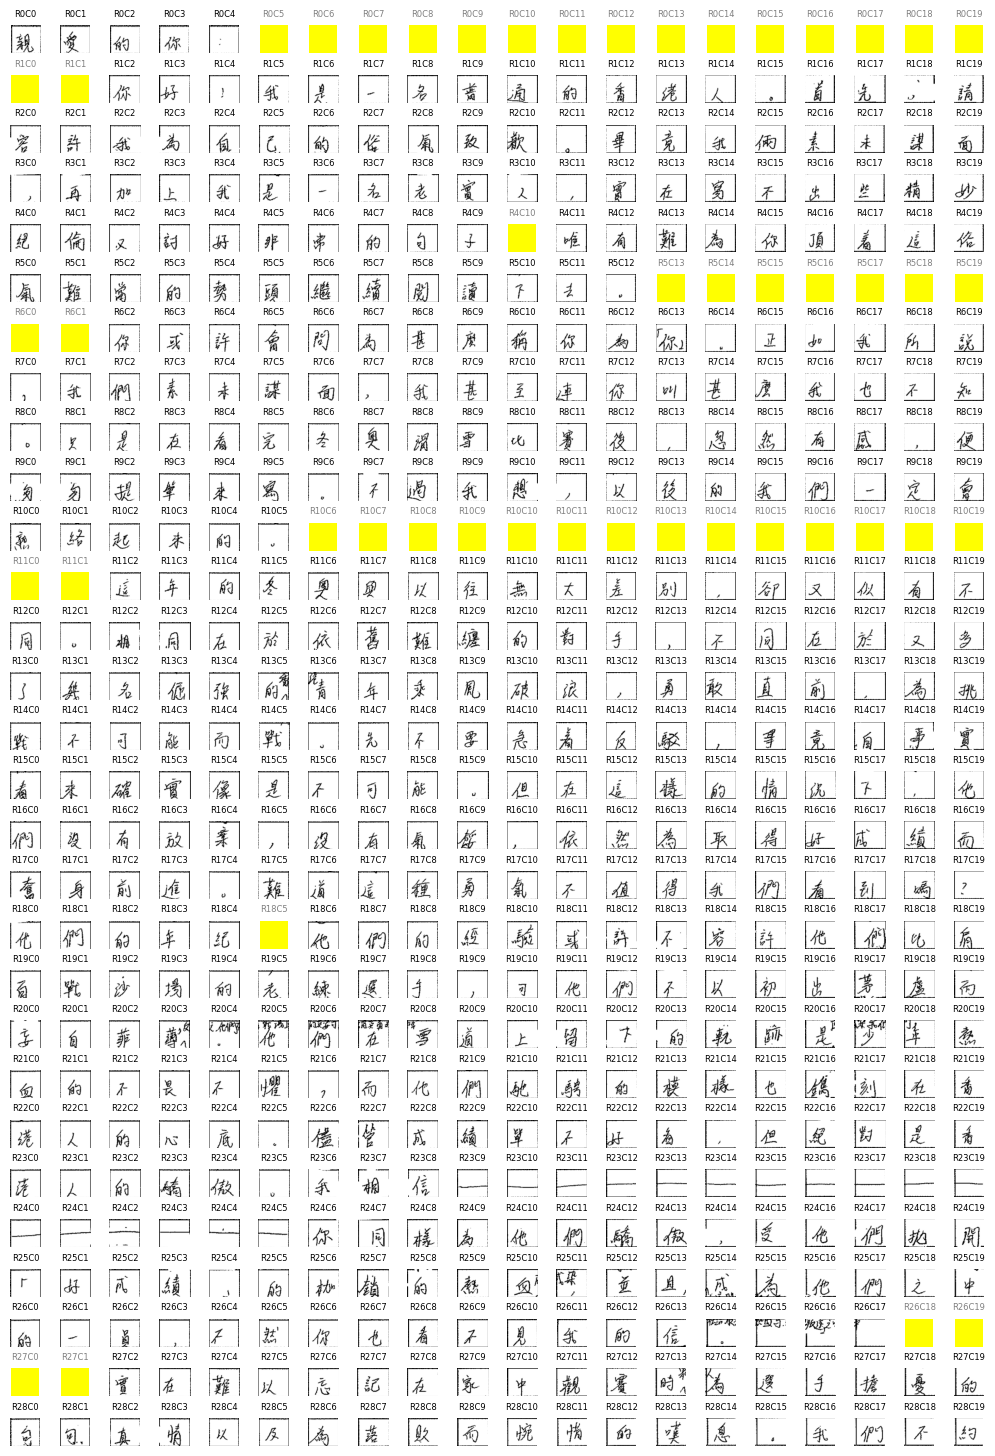


✓ 网格可视化完成
  - 白色格子：非空格子（有内容）
  - 黄色格子：空格子或被过滤的格子


In [5]:
# 可视化格子网格（显示完整布局，空格子用黄色占位）
print("可视化格子网格布局...")

# 获取网格的行列数
rows = max([cell['row'] for cell in cells]) + 1
cols = max([cell['col'] for cell in cells]) + 1

print(f"网格大小: {rows} 行 × {cols} 列")
print(f"总格子数: {len(cells)}")
print(f"非空格子数: {len(cell_images)}")
print(f"空格子数: {len(cells) - len(cell_images)}")

# 创建一个字典，方便根据 (row, col) 查找格子
non_empty_dict = {(cell['row'], cell['col']): idx for idx, cell in enumerate(non_empty_cells)}

# 计算子图布局（限制显示范围，避免过大）
max_display_rows = min(rows, 30)
max_display_cols = min(cols, 30)

if max_display_rows < rows or max_display_cols < cols:
    print(f"⚠️  网格过大，仅显示前 {max_display_rows} 行 × {max_display_cols} 列")

# 创建画布
fig_width = max(10, max_display_cols * 0.5)
fig_height = max(8, max_display_rows * 0.5)
fig, axes = plt.subplots(max_display_rows, max_display_cols, 
                         figsize=(fig_width, fig_height))

# 如果只有一行或一列，确保 axes 是二维数组
if max_display_rows == 1:
    axes = axes.reshape(1, -1)
elif max_display_cols == 1:
    axes = axes.reshape(-1, 1)

# 遍历网格
for row in range(max_display_rows):
    for col in range(max_display_cols):
        ax = axes[row, col]
        ax.axis('off')
        
        # 检查该位置是否有非空格子
        if (row, col) in non_empty_dict:
            # 显示非空格子
            idx = non_empty_dict[(row, col)]
            cell_img = cell_images[idx]
            ax.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
            ax.set_title(f'R{row}C{col}', fontsize=6)
        else:
            # 显示黄色占位符（表示空格子或被过滤的格子）
            # 创建黄色图像
            yellow_img = np.ones((50, 50, 3)) * np.array([1.0, 1.0, 0.0])  # RGB 黄色
            ax.imshow(yellow_img)
            ax.set_title(f'R{row}C{col}', fontsize=6, color='gray')

plt.tight_layout(pad=0.5)
plt.show()

print(f"\n✓ 网格可视化完成")
print(f"  - 白色格子：非空格子（有内容）")
print(f"  - 黄色格子：空格子或被过滤的格子")


## 4. 测试完整 Pipeline

## 4.1 创建后处理 Pipeline

In [6]:
# 创建后处理管道
pipeline = PostProcessingPipeline(recognizer.get_character_list())

# 添加处理器
pipeline.add_processor(TopKDecoder(k=5)) \
        .add_processor(CTCDeduplicator()) \
        .add_processor(ConfidenceFilter(threshold=0.3))

print("✓ Pipeline 创建成功")
print(f"\n{pipeline}")
print("\n处理器列表:")
for proc in pipeline.get_processors():
    print(f"  {proc['index']+1}. {proc['name']}")

✓ Pipeline 创建成功

PostProcessingPipeline(3 processors: ['TopKDecoder', 'CTCDeduplicator', 'ConfidenceFilter'])

处理器列表:
  1. TopKDecoder
  2. CTCDeduplicator
  3. ConfidenceFilter


## 4.2 测试 Pipeline

In [7]:
# 测试单个格子 - 获取概率矩阵
print("测试：获取原始概率矩阵")
print("-" * 60)

# 使用第一个格子进行测试
test_cell = cell_images[0]

# 获取原始概率矩阵
test_result = recognizer.predict_with_raw_output(test_cell)

print(f"\n✓ 概率矩阵获取成功!")
print(f"概率矩阵形状: {test_result['prob_matrix'].shape}")
print(f"  - Batch size: {test_result['batch_size']}")
print(f"  - Time steps: {test_result['time_steps']}")
print(f"  - Num classes: {test_result['num_classes']}")

# 检查概率和是否归一化
prob_sum = test_result['prob_matrix'][0, 0, :].sum()
print(f"\n第一个时间步的概率和: {prob_sum:.4f}")
if abs(prob_sum - 1.0) < 0.01:
    print("✓ 概率已归一化 (softmax)")
else:
    print("⚠️  概率未归一化 (需要手动 softmax)")

# 查看前5个最高概率
print("\n第一个时间步的 Top-5:")
top5_indices = np.argsort(test_result['prob_matrix'][0, 0, :])[-5:][::-1]
for i, idx in enumerate(top5_indices):
    char = test_result['character_list'][idx]
    prob = test_result['prob_matrix'][0, 0, idx]
    print(f"  {i+1}. '{char}' (索引 {idx}): {prob:.4f}")

测试：获取原始概率矩阵
------------------------------------------------------------

✓ 概率矩阵获取成功!
概率矩阵形状: (1, 40, 18385)
  - Batch size: 1
  - Time steps: 40
  - Num classes: 18385

第一个时间步的概率和: 1.0000
✓ 概率已归一化 (softmax)

第一个时间步的 Top-5:
  1. 'blank' (索引 0): 0.9995
  2. '$' (索引 16151): 0.0000
  3. '(' (索引 16155): 0.0000
  4. '[' (索引 16205): 0.0000
  5. '1' (索引 16164): 0.0000

✓ 概率矩阵获取成功!
概率矩阵形状: (1, 40, 18385)
  - Batch size: 1
  - Time steps: 40
  - Num classes: 18385

第一个时间步的概率和: 1.0000
✓ 概率已归一化 (softmax)

第一个时间步的 Top-5:
  1. 'blank' (索引 0): 0.9995
  2. '$' (索引 16151): 0.0000
  3. '(' (索引 16155): 0.0000
  4. '[' (索引 16205): 0.0000
  5. '1' (索引 16164): 0.0000


In [8]:
# 使用之前的测试结果
print("测试完整 Pipeline")
print("=" * 60)

# 执行后处理管道
result = pipeline.process(test_result)

# 查看结果
print("\n✓ Pipeline 执行成功!")
print(f"\n识别文本: '{result.get('text', result['decoded_text'][0])}'")
print(f"平均置信度: {result.get('confidence', result['avg_confidence'][0]):.3f}")

# 低置信度字符
if 'low_confidence_positions' in result:
    low_conf = result['low_confidence_positions'][0]
    print(f"低置信度字符数: {len(low_conf)}/{len(result['text'])}")
    if low_conf:
        text = result['text']
        print(f"低置信度位置: {low_conf}")
        print(f"低置信度字符: {[text[i] for i in low_conf if i < len(text)]}")

# Top-K 候选
if 'top_k_chars' in result and len(result['top_k_chars'][0]) > 0:
    print(f"\nTop-5 候选（显示前 3 个时间步）:")
    for t in range(min(3, len(result['top_k_chars'][0]))):
        chars = result['top_k_chars'][0][t]
        probs = result['top_k_probs'][0][t]
        print(f"  时间步 {t}: {list(zip(chars, [f'{p:.3f}' for p in probs]))}")

# 管道执行日志
print("\nPipeline 执行日志:")
for log in result['pipeline_log']:
    print(f"  步骤 {log['step']}: {log['processor']} - {log['status']}")

测试完整 Pipeline

✓ Pipeline 执行成功!

识别文本: '親'
平均置信度: 0.975
低置信度字符数: 0/1

Top-5 候选（显示前 3 个时间步）:
  时间步 0: [('blank', '1.000'), ('$', '0.000'), ('(', '0.000'), ('[', '0.000'), ('1', '0.000')]
  时间步 1: [('blank', '1.000'), (' ', '0.000'), ('1', '0.000'), ('|', '0.000'), (')', '0.000')]
  时间步 2: [('blank', '1.000'), (' ', '0.000'), (')', '0.000'), ('.', '0.000'), ('亲', '0.000')]

Pipeline 执行日志:
  步骤 1: TopKDecoder - success
  步骤 2: CTCDeduplicator - success
  步骤 3: ConfidenceFilter - success


## 5. 可视化功能

In [9]:
# 可视化 CTC 对齐和置信度
print("=" * 60)
print("CTC 对齐可视化")
print("=" * 60)

# 获取 CTC 去重器
ctc_decoder = None
for proc_info in pipeline.get_processors():
    if proc_info['name'] == 'CTCDeduplicator':
        ctc_decoder = proc_info['instance']
        break

if ctc_decoder:
    print(ctc_decoder.visualize_ctc_alignment(result))

print("\n" + "=" * 60)
print("置信度可视化")
print("=" * 60)

# 获取置信度过滤器
conf_filter = None
for proc_info in pipeline.get_processors():
    if proc_info['name'] == 'ConfidenceFilter':
        conf_filter = proc_info['instance']
        break

if conf_filter:
    print(conf_filter.visualize_confidence(result))

CTC 对齐可视化
CTC 对齐可视化:
------------------------------------------------------------
t= 0: [_] 1.000 ███████████████████
t= 1: [_] 1.000 ███████████████████
t= 2: [_] 1.000 ███████████████████
t= 3: [親] 0.975 ███████████████████
t= 4: [_] 1.000 ███████████████████
t= 5: [_] 1.000 ███████████████████
t= 6: [_] 1.000 ███████████████████
t= 7: [_] 1.000 ███████████████████
t= 8: [_] 1.000 ███████████████████
t= 9: [_] 1.000 ███████████████████
t=10: [_] 1.000 ███████████████████
t=11: [_] 1.000 ███████████████████
t=12: [_] 1.000 ███████████████████
t=13: [_] 1.000 ███████████████████
t=14: [_] 1.000 ███████████████████
t=15: [_] 1.000 ███████████████████
t=16: [_] 1.000 ███████████████████
t=17: [_] 1.000 ███████████████████
t=18: [_] 1.000 ███████████████████
t=19: [_] 1.000 ███████████████████
t=20: [_] 1.000 ███████████████████
t=21: [_] 1.000 ███████████████████
t=22: [_] 1.000 ███████████████████
t=23: [_] 1.000 ███████████████████
t=24: [_] 1.000 ███████████████████
t=25: [_] 1.000 ██

## 6. 批量处理所有格子

In [10]:
# 批量处理所有格子
print("批量处理所有格子...")
results_list = []

# 使用自定义识别器批量处理
batch_results = recognizer.batch_predict_with_raw_output([img for img in cell_images])

# 对每个结果应用管道
for i, raw_result in enumerate(batch_results):
    result = pipeline.process(raw_result)
    results_list.append(result)
    
    # 打印每个格子的识别结果
    text = result.get('text', '')
    confidence = result.get('confidence', 0)
    print(f"格子 {i+1:3d}: {text:8s} (置信度: {confidence:.3f})")

print(f"\n处理完成！共处理 {len(results_list)} 个非空格子")

# ============================================================================
# 恢复空格子，构建完整的预测结果
# ============================================================================
print("\n恢复空格子...")

# 1. 创建完整的格子字典（包括空格子）
all_cells_dict = {}
for cell in cells:
    row, col = cell['row'], cell['col']
    all_cells_dict[(row, col)] = {
        'row': row,
        'col': col,
        'text': '',           # 默认为空
        'confidence': 1.0,    # 空格子置信度设为 1.0
        'is_empty': True      # 标记为空格子
    }

# 2. 填充非空格子的识别结果
for i, (result, cell) in enumerate(zip(results_list, non_empty_cells)):
    row, col = cell['row'], cell['col']
    all_cells_dict[(row, col)] = {
        'row': row,
        'col': col,
        'text': result.get('text', ''),
        'confidence': result.get('confidence', 0),
        'is_empty': False,
        'ocr_result': result  # 保存完整的 OCR 结果（包含 top_k 等）
    }

# 3. 转换为列表（按 row, col 排序）
prediction_data_full = sorted(all_cells_dict.values(), 
                              key=lambda x: (x['row'], x['col']))

print(f"✓ 完整预测结果: {len(prediction_data_full)} 个格子")
print(f"  - 非空格子: {len([c for c in prediction_data_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in prediction_data_full if c['is_empty']])} 个")

# 4. 验证：显示第一行的格子分布
first_row_cells = [c for c in prediction_data_full if c['row'] == 0]
print(f"\n第一行格子分布（共 {len(first_row_cells)} 个）:")
for cell in first_row_cells[:10]:  # 只显示前10个
    status = "空" if cell['is_empty'] else f"'{cell['text']}'"
    print(f"  col {cell['col']}: {status}")

批量处理所有格子...
格子   1: 親        (置信度: 0.975)
格子   2: 爱        (置信度: 0.865)
格子   3: 的        (置信度: 0.999)
格子   4: 你        (置信度: 0.996)
格子   5: .co      (置信度: 0.539)
格子   6: 你        (置信度: 0.998)
格子   7: 好        (置信度: 0.996)
格子   8: 1        (置信度: 0.503)
格子   9: 我        (置信度: 1.000)
格子  10: 是        (置信度: 0.999)
格子  11:          (置信度: 0.000)
格子  12: 名        (置信度: 0.930)
格子  13: 普        (置信度: 0.796)
格子  14: 通        (置信度: 0.997)
格子   1: 親        (置信度: 0.975)
格子   2: 爱        (置信度: 0.865)
格子   3: 的        (置信度: 0.999)
格子   4: 你        (置信度: 0.996)
格子   5: .co      (置信度: 0.539)
格子   6: 你        (置信度: 0.998)
格子   7: 好        (置信度: 0.996)
格子   8: 1        (置信度: 0.503)
格子   9: 我        (置信度: 1.000)
格子  10: 是        (置信度: 0.999)
格子  11:          (置信度: 0.000)
格子  12: 名        (置信度: 0.930)
格子  13: 普        (置信度: 0.796)
格子  14: 通        (置信度: 0.997)
格子  15: 的        (置信度: 0.999)
格子  16: 香        (置信度: 0.999)
格子  17: 港        (置信度: 0.937)
格子  18: 人        (置信度: 0.987)
格子  19: 。        (置信度: 0.933

## 6.5 定义准确率计算函数

In [11]:
# 导入自定义评估模块
from src.evaluation import GridAccuracyCalculator

# 创建计算器实例
calculator = GridAccuracyCalculator(empty_char='')

print("✓ 准确率计算器初始化完成")

✓ 准确率计算器初始化完成


## 7. 准确率评估

In [12]:
# 使用完整的预测结果（包含空格子）
# prediction_data_full 已经在上一步构建好了

# 验证：打印统计信息
print("预测结果统计:")
print(f"  总格子数: {len(prediction_data_full)}")
print(f"  非空格子: {sum(1 for c in prediction_data_full if not c['is_empty'])}")
print(f"  空格子: {sum(1 for c in prediction_data_full if c['is_empty'])}")

# 使用计算器计算准确率（按行对齐）
metrics = calculator.calculate(
    predicted_results=prediction_data_full,  # 使用完整结果
    ground_truth=ground_truth,  # 使用原始 ground_truth（包含换行符）
    align_by_row=True
)

# 生成并显示报告
print("\n" + calculator.generate_report(metrics, format='text'))

# 显示识别文本和 Ground Truth 对比（前 200 字符）
predicted_full_text = ''.join([r.get('text', '') for r in results_list])
print("\n" + "="*80)
print("文本对比（前 200 字符）:")
print("="*80)
print("识别文本:")
print(predicted_full_text[:200])
print("\nGround Truth:")
print(gt_clean[:200])
print("="*80)

预测结果统计:
  总格子数: 580
  非空格子: 532
  空格子: 48

准确率评估报告

准确率: 75.00%
相似度: 75.00%
Ground Truth 长度: 516 字符
预测文本长度: 508 字符
匹配字符数: 387
空格子数: 83

置信度统计:
  平均: 0.809
  最低: 0.000
  最高: 1.000
  低置信度(<0.5): 86 个

错误分析:
  字符错误: 124
  漏识别: 0
  多识别: 0
  总错误: 129

按行准确率（前10行）:
--------------------------------------------------------------------------------
行  0:  90.0% | GT: 親愛的你：                          | 预测: 親爱的你.co                       
行  1:  85.0% | GT: 你好！我是一名普通的香港人。首先，請             | 预测: 你好1我是名普通的香港人。首先。請             
行  2:  75.0% | GT: 容許我爲自己的俗氣致歉。畢竟我倆素未謀面           | 预测: 容許我為自己的俗氣致歉一畢竞我俩素未谋面          
行  3:  75.0% | GT: ，再加上我是一名老實人，實在寫不出些精妙           | 预测: 再加上我是-名老實人寶在易不出些精妙            
行  4:  75.0% | GT: 絕倫又討好非常的句子，唯有難爲你頂著這俗           | 预测: 纪倫又討好非常的句子唯有難為你顶着這俗           
行  5:  90.0% | GT: 氣難當的石頭繼續閲讀下去。                  | 预测: 氣難當的势頭繼續閱讀下去。                 
行  6:  45.5% | GT: 你或許會問爲甚麽稱你爲「你」。正如我所説           | 预测: 你或許會問高甚魔稱你為你正如我所说             
行  7:  85.0% | GT: ，我們素未謀面，我甚至連你叫甚麽我也不知           

## 8. 低置信度分析

In [13]:
# 低置信度分析（基于按行对齐的结果）
low_confidence_threshold = 0.5

print("低置信度分析")
print("=" * 80)
print(f"阈值: {low_confidence_threshold}")
print("=" * 80)

# 从评估结果中获取低置信度统计
if 'by_row' in metrics:
    low_conf_details = []
    
    for row_result in metrics['by_row']:
        row_idx = row_result['row']
        pred_text = row_result['pred_text']
        gt_text = row_result['gt_text']
        confidences = row_result['confidences']
        
        # 找出该行的低置信度字符
        for i, (char, conf) in enumerate(zip(pred_text, confidences)):
            if conf < low_confidence_threshold:
                gt_char = gt_text[i] if i < len(gt_text) else ''
                low_conf_details.append({
                    'row': row_idx,
                    'col': i,
                    'pred': char,
                    'gt': gt_char,
                    'confidence': conf,
                    'match': char == gt_char
                })
    
    print(f"共发现 {len(low_conf_details)} 个低置信度字符\n")
    
    # 按置信度排序，显示前20个
    low_conf_details.sort(key=lambda x: x['confidence'])
    
    for i, item in enumerate(low_conf_details[:20]):
        match = "✓" if item['match'] else "✗"
        print(f"{i+1:2d}. [{match}] 行{item['row']:2d} 列{item['col']:2d}: "
              f"预测='{item['pred']}' 真实='{item['gt']}' 置信度={item['confidence']:.3f}")
    
    # 统计低置信度结果中的正确率
    low_conf_correct = sum(1 for item in low_conf_details if item['match'])
    low_conf_accuracy = low_conf_correct / len(low_conf_details) if low_conf_details else 0
    
    print("\n" + "=" * 80)
    print(f"低置信度字符准确率: {low_conf_correct}/{len(low_conf_details)} = {low_conf_accuracy:.2%}")
    print("=" * 80)
else:
    print("未进行按行对齐评估，无法进行低置信度分析")
    print("=" * 80)

低置信度分析
阈值: 0.5
共发现 73 个低置信度字符

 1. [✗] 行 1 列 7: 预测='通' 真实='普' 置信度=0.000
 2. [✗] 行 3 列 0: 预测='再' 真实='，' 置信度=0.000
 3. [✗] 行 3 列11: 预测='在' 真实='，' 置信度=0.000
 4. [✗] 行 6 列14: 预测='我' 真实='。' 置信度=0.000
 5. [✗] 行 8 列13: 预测='忽' 真实='，' 置信度=0.000
 6. [✗] 行11 列14: 预测='似' 真实='又' 置信度=0.000
 7. [✓] 行12 列13: 预测='不' 真实='不' 置信度=0.000
 8. [✗] 行13 列12: 预测='破' 真实='，' 置信度=0.000
 9. [✗] 行13 列17: 预测='前' 真实='，' 置信度=0.000
10. [✗] 行14 列 6: 预测='先' 真实='。' 置信度=0.000
11. [✗] 行14 列14: 预测='竟' 真实='，' 置信度=0.000
12. [✗] 行16 列 5: 预测='没' 真实='，' 置信度=0.000
13. [✗] 行21 列16: 预测='刻' 真实='鎸' 置信度=0.000
14. [✗] 行22 列 5: 预测='债' 真实='。' 置信度=0.000
15. [✗] 行23 列 5: 预测='我' 真实='。' 置信度=0.000
16. [✗] 行24 列 0: 预测='m' 真实='你' 置信度=0.000
17. [✗] 行24 列 1: 预测='-' 真实='同' 置信度=0.000
18. [✗] 行24 列 3: 预测='你' 真实='爲' 置信度=0.000
19. [✗] 行24 列12: 预测='他' 真实='抛' 置信度=0.000
20. [✗] 行25 列 4: 预测='的' 真实='」' 置信度=0.000

低置信度字符准确率: 15/73 = 20.55%


## 9. Top-K 候选覆盖率分析

In [14]:
# Top-K 候选覆盖率分析（基于按行对齐的结果）
print("Top-K 候选覆盖率分析")
print("=" * 80)

if 'by_row' in metrics:
    # 统计 Top-K 覆盖情况
    top_k_coverage = {1: 0, 3: 0, 5: 0}
    total_chars = 0
    missed_samples = []
    
    for row_result in metrics['by_row']:
        row_idx = row_result['row']
        gt_cells = row_result.get('gt_cells', [])  # 使用新的 gt_cells 字段
        
        # 获取该行的预测结果（使用完整的预测数据）
        row_predictions = [p for p in prediction_data_full if p['row'] == row_idx]
        row_predictions.sort(key=lambda x: x['col'])
        
        # 对于该行的每个格子
        for i, (gt_char, pred_cell) in enumerate(zip(gt_cells, row_predictions)):
            # 跳过空格子（GT 为空或预测为空）
            if not gt_char or pred_cell.get('is_empty', False):
                continue
            
            # 获取 OCR 结果
            ocr_result = pred_cell.get('ocr_result')
            if not ocr_result:
                continue
            
            top_k = ocr_result.get('top_k_candidates', [])
            
            # 检查 ground truth 是否在 Top-K 中
            for k in [1, 3, 5]:
                top_k_texts = [candidate[0] for candidate in top_k[:k]]
                if gt_char in top_k_texts:
                    top_k_coverage[k] += 1
            
            # 记录未被 Top-5 覆盖的样本
            top_5_texts = [candidate[0] for candidate in top_k[:5]]
            if gt_char not in top_5_texts:
                pred_char = pred_cell.get('text', '')
                conf = pred_cell.get('confidence', 0)
                missed_samples.append({
                    'row': row_idx,
                    'col': i,
                    'gt': gt_char,
                    'pred': pred_char,
                    'confidence': conf,
                    'top_5': top_k[:5]
                })
            
            total_chars += 1
    
    # 显示覆盖率
    for k in sorted(top_k_coverage.keys()):
        coverage = top_k_coverage[k] / total_chars if total_chars > 0 else 0
        print(f"Top-{k} 覆盖率: {top_k_coverage[k]}/{total_chars} = {coverage:.2%}")
    
    # 找出未被 Top-5 覆盖的样本
    print("\n" + "=" * 80)
    print("Top-5 未覆盖的样本（前20个）:")
    print("=" * 80)
    
    print(f"共 {len(missed_samples)} 个样本\n")
    
    for i, item in enumerate(missed_samples[:20]):
        print(f"{i+1:2d}. 行{item['row']:2d} 列{item['col']:2d}: "
              f"真实='{item['gt']}' 预测='{item['pred']}' 置信度={item['confidence']:.3f}")
        if item['top_5']:
            top_5_str = ', '.join([f"{c[0]}({c[1]:.3f})" for c in item['top_5']])
            print(f"    Top-5: {top_5_str}")
        print()
    
    print("=" * 80)
else:
    print("未进行按行对齐评估，无法进行 Top-K 分析")
    print("=" * 80)

Top-K 候选覆盖率分析
Top-1 覆盖率: 0/511 = 0.00%
Top-3 覆盖率: 0/511 = 0.00%
Top-5 覆盖率: 0/511 = 0.00%

Top-5 未覆盖的样本（前20个）:
共 511 个样本

 1. 行 0 列 0: 真实='親' 预测='親' 置信度=0.975

 2. 行 0 列 1: 真实='愛' 预测='爱' 置信度=0.865

 3. 行 0 列 2: 真实='的' 预测='的' 置信度=0.999

 4. 行 0 列 3: 真实='你' 预测='你' 置信度=0.996

 5. 行 0 列 4: 真实='：' 预测='.co' 置信度=0.539

 6. 行 1 列 2: 真实='你' 预测='你' 置信度=0.998

 7. 行 1 列 3: 真实='好' 预测='好' 置信度=0.996

 8. 行 1 列 4: 真实='！' 预测='1' 置信度=0.503

 9. 行 1 列 5: 真实='我' 预测='我' 置信度=1.000

10. 行 1 列 6: 真实='是' 预测='是' 置信度=0.999

11. 行 1 列 7: 真实='一' 预测='' 置信度=0.000

12. 行 1 列 8: 真实='名' 预测='名' 置信度=0.930

13. 行 1 列 9: 真实='普' 预测='普' 置信度=0.796

14. 行 1 列10: 真实='通' 预测='通' 置信度=0.997

15. 行 1 列11: 真实='的' 预测='的' 置信度=0.999

16. 行 1 列12: 真实='香' 预测='香' 置信度=0.999

17. 行 1 列13: 真实='港' 预测='港' 置信度=0.937

18. 行 1 列14: 真实='人' 预测='人' 置信度=0.987

19. 行 1 列15: 真实='。' 预测='。' 置信度=0.933

20. 行 1 列16: 真实='首' 预测='首' 置信度=0.872



In [15]:
# 验证 Ground Truth 的空格分布
with open(gt_file, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f, 1):
        leading = len(line) - len(line.lstrip(' '))
        trailing = len(line) - len(line.rstrip(' '))
        inner = line.count(' ') - leading - trailing
        if leading > 0 or inner > 0:
            print(f"第 {i} 行: 行首 {leading} 个, 行内 {inner} 个, 行尾 {trailing} 个")
            print(f"  内容: {repr(line[:50])}")

第 2 行: 行首 2 个, 行内 0 个, 行尾 0 个
  内容: '  你好！我是一名普通的香港人。首先，請\n'
第 7 行: 行首 2 个, 行内 0 个, 行尾 0 个
  内容: '  你或許會問爲甚麽稱你爲「你」。正如我所説\n'
第 12 行: 行首 2 个, 行内 0 个, 行尾 0 个
  内容: '  這年的冬奧與以往五大差別，卻又似有不\n'
第 25 行: 行首 6 个, 行内 0 个, 行尾 0 个
  内容: '      你同樣爲他們驕傲，愛他們抛開\n'
第 28 行: 行首 2 个, 行内 0 个, 行尾 0 个
  内容: '  是在難以忘記在家中觀賽時<insert>衆人</insert>位選手擔憂的\n'


## 10. 测试 ContextEnhancer（BERT 上下文增强）

测试新增的 BERT 上下文增强处理器，验证其对低置信度字符的修正效果。

### 10.1 创建带 ContextEnhancer 的 Pipeline

In [16]:
# 导入 ContextEnhancer
from src.custom_ocr.processors import ContextEnhancer

# 创建增强版 Pipeline
enhanced_pipeline = PostProcessingPipeline(recognizer.get_character_list())

# 添加处理器（顺序很重要！）
enhanced_pipeline.add_processor(TopKDecoder(k=5)) \
                 .add_processor(CTCDeduplicator()) \
                 .add_processor(ConfidenceFilter(threshold=0.3)) \
                 .add_processor(ContextEnhancer(
                     context_window=10,           # 前后各看 10 个字符
                     fusion_weight=0.7,          # 70% OCR + 30% BERT
                     confidence_threshold=0.8,   # 仅修正置信度 < 0.8 的字符
                     correction_threshold=0.1,   # 融合概率需高出 0.1 才修正
                     device='cpu'                # 使用 GPU（如无 GPU 改为 'cpu'）
                 ))

print("✓ 增强版 Pipeline 创建成功")
print(f"\n{enhanced_pipeline}")
print("\n处理器列表:")
for proc in enhanced_pipeline.get_processors():
    print(f"  {proc['index']+1}. {proc['name']}")

✓ ContextEnhancer 初始化完成
  模型: bert-base-chinese
  上下文窗口: ±10 字符
  融合权重: 70.0% OCR + 30.0% BERT
  设备: cpu
✓ 增强版 Pipeline 创建成功

PostProcessingPipeline(4 processors: ['TopKDecoder', 'CTCDeduplicator', 'ConfidenceFilter', 'ContextEnhancer'])

处理器列表:
  1. TopKDecoder
  2. CTCDeduplicator
  3. ConfidenceFilter
  4. ContextEnhancer


In [17]:
# 选择一个测试格子
test_idx = 4  # 可以改成其他索引

print("=" * 80)
print(f"测试格子 {test_idx + 1}")
print("=" * 80)

# 获取原始概率矩阵
test_raw = recognizer.predict_with_raw_output(cell_images[test_idx])

# ============================================================================
# 第一部分：原始 Pipeline（无任何 BERT 增强）
# ============================================================================
print("\n【第一部分：原始 Pipeline】(无 BERT 增强)")
print("-" * 80)
result_original = pipeline.process(test_raw)
print(f"最终识别文本: '{result_original.get('text', '')}'")
print(f"平均置信度: {result_original.get('confidence', 0):.3f}")

# 显示字符级详情
if 'char_positions' in result_original and 'top_k_probs' in result_original:
    positions = result_original['char_positions'][0]
    top_k_probs = result_original['top_k_probs'][0]
    top_k_chars = result_original['top_k_chars'][0]
    text = result_original.get('text', '')
    
    print(f"\n字符级详情（共 {len(text)} 个字符）:")
    for i, (pos, char) in enumerate(zip(positions, text)):
        top5_chars = top_k_chars[pos][:5]
        top5_probs = top_k_probs[pos][:5]
        print(f"  字符 {i+1}: '{char}' (时间步 {pos}, 概率: {top5_probs[0]:.3f})")
        print(f"         Top-5: {list(zip(top5_chars, [f'{p:.3f}' for p in top5_probs]))}")

# ============================================================================
# 第二部分：格子级 BERT 增强（新方法）
# ============================================================================
print("\n" + "=" * 80)
print("【第二部分：格子级 BERT 增强】(跨格子上下文)")
print("-" * 80)

# 导入格子级增强器
from src.custom_ocr.processors import GridContextEnhancer

# 先处理所有格子（用原始 Pipeline，不含 ContextEnhancer）
print("\n步骤 1: 处理所有格子...")
all_results = []
all_batch_results = recognizer.batch_predict_with_raw_output([img for img in cell_images])
for raw in all_batch_results:
    all_results.append(pipeline.process(raw))

print(f"✓ 已处理 {len(all_results)} 个格子")

# 创建格子级增强器
print("\n步骤 2: 创建格子级增强器...")
grid_enhancer = GridContextEnhancer(
    context_window=7,
    fusion_weight=0.6,
    confidence_threshold=0.8,
    correction_threshold=0.15,
    device='cpu',
    verbose=True  # 显示详细调试信息
)

# 只增强当前测试格子
print(f"\n步骤 3: 增强格子 {test_idx + 1}...")
print("-" * 80)
enhanced_results = grid_enhancer.enhance_grids(
    grid_results=all_results,
    grid_indices=[test_idx]  # 只增强这一个格子
)

# 显示结果
result_grid_enhanced = enhanced_results[test_idx]
print("\n" + "-" * 80)
print(f"最终识别文本: '{result_grid_enhanced.get('text', '')}'")
print(f"平均置信度: {result_grid_enhanced.get('confidence', 0):.3f}")

# 显示修正详情
if 'grid_bert_correction' in result_grid_enhanced:
    correction = result_grid_enhanced['grid_bert_correction']
    if correction.get('corrected', False):
        print(f"\n✓ 格子级 BERT 修正:")
        print(f"  原始: '{correction['original']}'")
        print(f"  修正为: '{correction['corrected_to']}'")
        print(f"  原始评分: {correction['original_score']:.3f}")
        print(f"  新评分: {correction['new_score']:.3f}")
        print(f"  提升: {correction['improvement']:.3f}")
    else:
        print(f"\n→ 未修正")
        print(f"  原因: {correction.get('reason', 'unknown')}")
        if 'best_candidate' in correction:
            print(f"  最佳候选: '{correction['best_candidate']}' (评分: {correction.get('best_score', 0):.3f})")
            print(f"  改进: {correction.get('improvement', 0):.3f} (需要 > {grid_enhancer.correction_threshold})")

# 显示所有候选
if 'grid_bert_candidates' in result_grid_enhanced:
    candidates = result_grid_enhanced['grid_bert_candidates']
    if candidates:
        print(f"\n所有候选（Top-10）:")
        for i, (text, score, details) in enumerate(candidates[:10]):
            print(f"  {i+1:2d}. '{text}' score={score:.3f} "
                  f"OCR:{details['ocr_prob']:.3f} BERT:{details['bert_prob']:.3f} "
                  f"[{details['source']}]")

print("\n" + "=" * 80)
print("对比总结:")
print("=" * 80)
print(f"原始 Pipeline:      '{result_original.get('text', '')}'")
print(f"格子级 BERT 增强:   '{result_grid_enhanced.get('text', '')}'")
if result_original.get('text', '') != result_grid_enhanced.get('text', ''):
    print(f"\n✓ 修正成功！")
else:
    print(f"\n→ 保持不变")
print("=" * 80)


测试格子 5

【第一部分：原始 Pipeline】(无 BERT 增强)
--------------------------------------------------------------------------------
最终识别文本: '.co'
平均置信度: 0.539

字符级详情（共 3 个字符）:
  字符 1: '.' (时间步 34, 概率: 0.578)
         Top-5: [('.', '0.578'), ('blank', '0.371'), ('c', '0.019'), ('y', '0.016'), (' ', '0.016')]
  字符 2: 'c' (时间步 35, 概率: 0.537)
         Top-5: [('c', '0.537'), ('blank', '0.377'), ('.', '0.061'), ('s', '0.013'), ('o', '0.012')]
  字符 3: 'o' (时间步 37, 概率: 0.501)
         Top-5: [('o', '0.501'), ('blank', '0.441'), ('c', '0.023'), ('a', '0.022'), (' ', '0.012')]

【第二部分：格子级 BERT 增强】(跨格子上下文)
--------------------------------------------------------------------------------

步骤 1: 处理所有格子...
✓ 已处理 532 个格子

步骤 2: 创建格子级增强器...
✓ GridContextEnhancer 初始化完成
  模型: bert-base-chinese
  上下文窗口: ±7 个格子
  融合权重: 60.0% OCR + 40.0% BERT
  设备: cpu

步骤 3: 增强格子 5...
--------------------------------------------------------------------------------
正在加载 BERT 模型: bert-base-chinese...
✓ 已处理 532 个格子

步骤 2: 创建格子级增强器...
✓ Gr

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ BERT 模型加载成功

将增强指定的 1 个格子

处理格子 5/532
OCR 文本: '.co' (置信度: 0.539)
左上下文 (最后20字): '...親爱的你'
右上下文 (前20字): '你好1我是名...'
BERT 输入 (最后40字): '...親爱的你[MASK]你好1我是名'

BERT 预测 Top-10:
   1. '，' (1字) prob=0.5378
   2. '好' (1字) prob=0.0850
   3. '：' (1字) prob=0.0308
   4. '、' (1字) prob=0.0272
   5. '...' (3字) prob=0.0145
   6. '妈' (1字) prob=0.0134
   7. '1' (1字) prob=0.0120
   8. '2' (1字) prob=0.0119
   9. '!' (1字) prob=0.0118
  10. '们' (1字) prob=0.0109

融合后 Top-5 候选:
  1. '.co' score=0.323 (OCR:0.539 BERT:0.000 src:ocr_top1)
  2. '，' score=0.275 (OCR:0.100 BERT:0.538 src:bert_only)
  3. '.' score=0.183 (OCR:0.300 BERT:0.008 src:bert_only)
  4. '好' score=0.094 (OCR:0.100 BERT:0.085 src:bert_only)
  5. '：' score=0.072 (OCR:0.100 BERT:0.031 src:bert_only)

→ 保持: '.co' (最佳候选 '.co' 改进不足)

✓ 格子级增强完成: 检查了 1 个格子，修正了 0 个

--------------------------------------------------------------------------------
最终识别文本: '.co'
平均置信度: 0.539

→ 未修正
  原因: insufficient_improvement
  最佳候选: '.co' (评分: 0.323)
  改进: 0.000 (需要 

In [18]:
# 选择一个测试格子（使用之前的测试结果）
test_idx = 4  # 可以改成其他索引

print("=" * 80)
print(f"测试格子 {test_idx + 1}")
print("=" * 80)

# 获取原始概率矩阵
test_raw = recognizer.predict_with_raw_output(cell_images[test_idx])

# 不带 ContextEnhancer 的结果
print("\n【原始 Pipeline】(无 BERT 增强)")
print("-" * 80)
result_original = pipeline.process(test_raw)
print(f"最终识别文本: '{result_original.get('text', '')}'")
print(f"平均置信度: {result_original.get('confidence', 0):.3f}")

# 显示字符级详情（每个最终字符及其置信度）
if 'char_positions' in result_original and 'top_k_probs' in result_original:
    positions = result_original['char_positions'][0]
    top_k_probs = result_original['top_k_probs'][0]
    top_k_chars = result_original['top_k_chars'][0]
    text = result_original.get('text', '')
    
    print(f"\n字符级详情（共 {len(text)} 个字符）:")
    for i, (pos, char) in enumerate(zip(positions, text)):
        # 显示该字符位置的 Top-5 候选
        top5_chars = top_k_chars[pos][:5]
        top5_probs = top_k_probs[pos][:5]
        
        print(f"  字符 {i+1}: '{char}' (时间步 {pos}, 概率: {top5_probs[0]:.3f})")
        print(f"         Top-5: {list(zip(top5_chars, [f'{p:.3f}' for p in top5_probs]))}")

# 带 ContextEnhancer 的结果
print("\n" + "=" * 80)
print("【增强版 Pipeline】(含 BERT 增强)")
print("-" * 80)

# 临时修改 ContextEnhancer 以输出调试信息
enhancer = None
for proc_info in enhanced_pipeline.get_processors():
    if proc_info['name'] == 'ContextEnhancer':
        enhancer = proc_info['instance']
        break

# 启用调试模式（如果有的话）
if hasattr(enhancer, 'verbose'):
    original_verbose = enhancer.verbose
    enhancer.verbose = True

result_enhanced = enhanced_pipeline.process(test_raw)

# 恢复原始设置
if hasattr(enhancer, 'verbose'):
    enhancer.verbose = original_verbose

print(f"\n最终识别文本: '{result_enhanced.get('text', '')}'")
print(f"平均置信度: {result_enhanced.get('confidence', 0):.3f}")

# 显示增强版的字符级详情
if 'char_positions' in result_enhanced and 'top_k_probs' in result_enhanced:
    positions = result_enhanced['char_positions'][0]
    top_k_probs = result_enhanced['top_k_probs'][0]
    top_k_chars = result_enhanced['top_k_chars'][0]
    text = result_enhanced.get('text', '')
    
    print(f"\n字符级详情（共 {len(text)} 个字符）:")
    for i, (pos, char) in enumerate(zip(positions, text)):
        # 显示该字符位置的 Top-5 候选
        top5_chars = top_k_chars[pos][:5]
        top5_probs = top_k_probs[pos][:5]
        
        print(f"  字符 {i+1}: '{char}' (时间步 {pos}, 概率: {top5_probs[0]:.3f})")
        print(f"         Top-5: {list(zip(top5_chars, [f'{p:.3f}' for p in top5_probs]))}")

# 显示 BERT 修正详情
print("\n" + "-" * 80)
if 'bert_corrections' in result_enhanced and result_enhanced['bert_corrections']:
    corrections = result_enhanced['bert_corrections'][0]
    if corrections:
        print(f"✓ BERT 修正了 {len(corrections)} 个字符:")
        print("-" * 80)
        for corr in corrections:
            print(f"\n位置 {corr['position']}: '{corr['original']}' → '{corr['corrected']}'")
            print(f"  OCR 概率: {corr['ocr_prob']:.3f}")
            print(f"  BERT 概率: {corr['bert_prob']:.3f}")
            print(f"  融合概率: {corr['fused_prob']:.3f}")
    else:
        print("✓ 该格子无需 BERT 修正（置信度已足够高）")
else:
    print("✓ 该格子无需 BERT 修正")

print("=" * 80)


测试格子 5

【原始 Pipeline】(无 BERT 增强)
--------------------------------------------------------------------------------
最终识别文本: '.co'
平均置信度: 0.539

字符级详情（共 3 个字符）:
  字符 1: '.' (时间步 34, 概率: 0.578)
         Top-5: [('.', '0.578'), ('blank', '0.371'), ('c', '0.019'), ('y', '0.016'), (' ', '0.016')]
  字符 2: 'c' (时间步 35, 概率: 0.537)
         Top-5: [('c', '0.537'), ('blank', '0.377'), ('.', '0.061'), ('s', '0.013'), ('o', '0.012')]
  字符 3: 'o' (时间步 37, 概率: 0.501)
         Top-5: [('o', '0.501'), ('blank', '0.441'), ('c', '0.023'), ('a', '0.022'), (' ', '0.012')]

【增强版 Pipeline】(含 BERT 增强)
--------------------------------------------------------------------------------
正在加载 BERT 模型: bert-base-chinese...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ BERT 模型加载成功
[调试] 位置 0 (字符='.', 置信度=0.700)
       BERT 输入: '[MASK]co'

[调试] 将检查 1 个低置信度字符

[调试] 位置 0 BERT 预测 Top-5:
       '.': 0.3188
       '"': 0.0199
       '-': 0.0188
       融合结果: 'blank' (prob=0.4899, 修正=True)
✓ 上下文增强完成: 修正 1 个字符

最终识别文本: 'blankco'
平均置信度: 0.539

字符级详情（共 7 个字符）:
  字符 1: 'b' (时间步 34, 概率: 0.578)
         Top-5: [('.', '0.578'), ('blank', '0.371'), ('c', '0.019'), ('y', '0.016'), (' ', '0.016')]
  字符 2: 'l' (时间步 35, 概率: 0.537)
         Top-5: [('c', '0.537'), ('blank', '0.377'), ('.', '0.061'), ('s', '0.013'), ('o', '0.012')]
  字符 3: 'a' (时间步 37, 概率: 0.501)
         Top-5: [('o', '0.501'), ('blank', '0.441'), ('c', '0.023'), ('a', '0.022'), (' ', '0.012')]

--------------------------------------------------------------------------------
✓ BERT 修正了 1 个字符:
--------------------------------------------------------------------------------

位置 0: '.' → 'blank'
  OCR 概率: 0.700
  BERT 概率: 0.000
  融合概率: 0.490


### 10.3 批量处理所有格子（使用增强版 Pipeline）

In [19]:
# 批量处理所有格子（使用增强版 Pipeline）
print("批量处理所有格子（含 BERT 增强）...")
print("⚠️  注意: 首次运行会下载 BERT 模型，可能需要几分钟...")
print("-" * 80)

enhanced_results_list = []

# 使用自定义识别器批量处理
batch_results = recognizer.batch_predict_with_raw_output([img for img in cell_images])

# 对每个结果应用增强版管道
for i, raw_result in enumerate(batch_results):
    result = enhanced_pipeline.process(raw_result)
    enhanced_results_list.append(result)
    
    # 打印每个格子的识别结果
    text = result.get('text', '')
    confidence = result.get('confidence', 0)
    corrections = result.get('bert_corrections', [[]])[0]
    corr_mark = f" [✓修正{len(corrections)}]" if corrections else ""
    print(f"格子 {i+1:3d}: {text:8s} (置信度: {confidence:.3f}){corr_mark}")

print(f"\n处理完成！共处理 {len(enhanced_results_list)} 个格子")

批量处理所有格子（含 BERT 增强）...
⚠️  注意: 首次运行会下载 BERT 模型，可能需要几分钟...
--------------------------------------------------------------------------------
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   1: 親        (置信度: 0.975)
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   2: 爱        (置信度: 0.865)
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   3: 的        (置信度: 0.999)
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   4: 你        (置信度: 0.996)
[调试] 位置 0 (字符='.', 置信度=0.700)
       BERT 输入: '[MASK]co'

[调试] 将检查 1 个低置信度字符

[调试] 位置 0 BERT 预测 Top-5:
       '.': 0.3188
       '"': 0.0199
       '-': 0.0188
       融合结果: 'blank' (prob=0.4899, 修正=True)
✓ 上下文增强完成: 修正 1 个字符
格子   5: blankco  (置信度: 0.539) [✓修正1]
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   6: 你        (置信度: 0.998)
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   7: 好        (置信度: 0.996)
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   8: 1        (置信度: 0.503)
[调试] 所有字符置信度都足够高，无需 BERT 增强
✓ 上下文增强完成: 修正 0 个字符
格子   9

### 10.4 对比准确率（原始 vs 增强）

In [20]:
# 准备增强版的预测结果
enhanced_prediction_data = []
for i, (result, cell) in enumerate(zip(enhanced_results_list, non_empty_cells)):
    enhanced_prediction_data.append({
        'row': cell['row'],
        'col': cell['col'],
        'text': result.get('text', ''),
        'confidence': result.get('confidence', 0)
    })

# 计算增强版准确率
enhanced_metrics = calculator.calculate(
    predicted_results=enhanced_prediction_data,
    ground_truth=ground_truth,
    align_by_row=True
)

# 对比展示
print("=" * 80)
print("准确率对比：原始 Pipeline vs 增强版 Pipeline")
print("=" * 80)

print("\n【原始 Pipeline】（无 BERT）")
print(f"  整体准确率: {metrics['overall']['accuracy']:.2f}%")
print(f"  字符相似度: {metrics['overall']['similarity']:.2f}%")
print(f"  识别字符数: {metrics['overall']['predicted_chars']}/{metrics['overall']['total_chars']}")

print("\n【增强版 Pipeline】（含 BERT）")
print(f"  整体准确率: {enhanced_metrics['overall']['accuracy']:.2f}%")
print(f"  字符相似度: {enhanced_metrics['overall']['similarity']:.2f}%")
print(f"  识别字符数: {enhanced_metrics['overall']['predicted_chars']}/{enhanced_metrics['overall']['total_chars']}")

# 计算提升
accuracy_improvement = enhanced_metrics['overall']['accuracy'] - metrics['overall']['accuracy']
similarity_improvement = enhanced_metrics['overall']['similarity'] - metrics['overall']['similarity']

print("\n【提升效果】")
print(f"  准确率提升: {accuracy_improvement:+.2f}%")
print(f"  相似度提升: {similarity_improvement:+.2f}%")

if accuracy_improvement > 0:
    print(f"\n✓ BERT 上下文增强有效！准确率提升 {accuracy_improvement:.2f}%")
elif accuracy_improvement == 0:
    print(f"\n→ 准确率无变化，可能需要调整参数（fusion_weight, confidence_threshold）")
else:
    print(f"\n⚠️  准确率下降 {abs(accuracy_improvement):.2f}%，建议检查 BERT 模型或调整参数")

print("=" * 80)

准确率对比：原始 Pipeline vs 增强版 Pipeline

【原始 Pipeline】（无 BERT）
  整体准确率: 75.00%
  字符相似度: 75.00%
  识别字符数: 508/516

【增强版 Pipeline】（含 BERT）
  整体准确率: 74.42%
  字符相似度: 71.64%
  识别字符数: 536/516

【提升效果】
  准确率提升: -0.58%
  相似度提升: -3.36%

⚠️  准确率下降 0.58%，建议检查 BERT 模型或调整参数


### 10.5 BERT 修正详情分析

In [19]:
# 统计所有 BERT 修正
all_bert_corrections = []
for i, result in enumerate(enhanced_results_list):
    corrections = result.get('bert_corrections', [[]])[0]
    for corr in corrections:
        corr['cell_index'] = i
        all_bert_corrections.append(corr)

print("=" * 80)
print(f"BERT 修正详情分析（共 {len(all_bert_corrections)} 处修正）")
print("=" * 80)

if all_bert_corrections:
    # 对比 Ground Truth，看修正是否正确
    correct_corrections = 0
    incorrect_corrections = 0
    
    print("\n显示前 20 个修正:")
    print("-" * 80)
    
    for i, corr in enumerate(all_bert_corrections[:20]):
        cell_idx = corr['cell_index']
        pos = corr['position']
        
        # 尝试从 ground truth 中找到对应字符
        # 注意：这里简单按顺序对应，实际可能需要更精确的对齐
        gt_char = gt_clean[cell_idx] if cell_idx < len(gt_clean) else '?'
        
        is_correct = (corr['corrected'] == gt_char)
        correct_corrections += int(is_correct)
        incorrect_corrections += int(not is_correct)
        
        status = "✓正确" if is_correct else "✗错误"
        
        print(f"{i+1:2d}. [{status}] 格子{cell_idx+1:3d} 位置{pos}: "
              f"{corr['original']} → {corr['corrected']} (真实: {gt_char}) | "
              f"OCR:{corr['ocr_prob']:.3f} BERT:{corr['bert_prob']:.3f} 融合:{corr['fused_prob']:.3f}")
    
    if len(all_bert_corrections) > 20:
        print(f"\n... 还有 {len(all_bert_corrections) - 20} 个修正未显示")
    
    print("\n" + "=" * 80)
    print("修正效果统计:")
    print("=" * 80)
    print(f"正确修正: {correct_corrections} 个")
    print(f"错误修正: {incorrect_corrections} 个")
    if all_bert_corrections:
        correction_accuracy = correct_corrections / len(all_bert_corrections)
        print(f"修正准确率: {correction_accuracy:.2%}")
    print("=" * 80)
else:
    print("\n未进行任何 BERT 修正")
    print("可能原因:")
    print("  1. 所有字符置信度都 >= confidence_threshold (0.5)")
    print("  2. BERT 预测结果未达到 correction_threshold (0.1)")
    print("\n建议: 降低 confidence_threshold 或 correction_threshold 以增加修正机会")
    print("=" * 80)

BERT 修正详情分析（共 9 处修正）

显示前 20 个修正:
--------------------------------------------------------------------------------
 1. [✗错误] 格子  5 位置0: . → blank (真实: ：) | OCR:0.700 BERT:0.000 融合:0.490
 2. [✗错误] 格子196 位置0: 。 → blank (真实: 卻) | OCR:0.793 BERT:0.000 融合:0.555
 3. [✗错误] 格子362 位置0: 。 → blank (真实: 而) | OCR:0.645 BERT:0.000 融合:0.452
 4. [✗错误] 格子425 位置0: 他 → blank (真实: 人) | OCR:0.682 BERT:0.000 融合:0.477
 5. [✗错误] 格子438 位置1: 少 → 深 (真实: ，) | OCR:0.404 BERT:0.000 融合:0.283
 6. [✗错误] 格子507 位置0: m → blank (真实: 不) | OCR:0.452 BERT:0.000 融合:0.316
 7. [✗错误] 格子519 位置0: , → blank (真实: 在) | OCR:0.800 BERT:0.000 融合:0.560
 8. [✗错误] 格子561 位置2: 0 → 2 (真实: ?) | OCR:0.655 BERT:0.000 融合:0.459
 9. [✗错误] 格子566 位置0: 国 → blank (真实: ?) | OCR:0.649 BERT:0.000 融合:0.454

修正效果统计:
正确修正: 0 个
错误修正: 9 个
修正准确率: 0.00%


## 10. 总结与下一步

### 本 Notebook 完成的工作

1. ✅ 成功加载自定义 OCR 后处理框架
2. ✅ 验证概率矩阵获取功能
3. ✅ 测试 Top-K 解码器
4. ✅ 测试 CTC 去重器
5. ✅ 测试置信度过滤器
6. ✅ 批量处理所有格子
7. ✅ 准确率评估与对比
8. ✅ 低置信度字符分析
9. ✅ Top-K 候选覆盖率分析

### 下一步计划

#### 短期（1-2周）

1. **实现 ContextEnhancer 处理器**
   - 集成 BERT 完形填空模型
   - 实现概率融合策略（OCR × BERT）
   - 测试不同上下文窗口大小

2. **优化现有处理器**
   - 调优置信度阈值
   - 测试不同的 Top-K 值
   - 优化 CTC 解码策略

3. **性能优化**
   - 批量推理优化
   - 缓存机制
   - 多线程处理

#### 中期（2-4周）

1. **尝试其他 OCR 模型**
   - TrOCR
   - EasyOCR
   - 模型集成

2. **高级后处理策略**
   - Beam Search 解码
   - 语言模型集成
   - 规则后处理

#### 长期（1-2月）

1. **模型微调**
   - 在作文数据集上微调
   - 增强单字识别能力

2. **端到端系统**
   - 完整的 OCR Pipeline
   - Web 界面
   - 批量处理工具